In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder

from sklearn.manifold import TSNE
from sklearn.manifold import MDS

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
df_average = pd.read_csv('../data/average_connectome_data.csv', header=0, index_col=0)

In [47]:
# filter the afferent / efferent based on hippocampal connections, create similarity matrix
hippocampal_regions = np.array(['DG','CA3','CA2','CA1v','CA1d','SUBv','SUBd'])

# FROM hippocampus (efferent)
df_avg_from = df_average[df_average.index.isin(hippocampal_regions)]

# TO hippocampus (afferent)
df_average_t = df_average.T
df_avg_to = df_average_t[df_average_t.index.isin(hippocampal_regions)]

# drop HPC columns
df_avg_from = df_avg_from.drop(hippocampal_regions, axis=1)
df_avg_to = df_avg_to.drop(hippocampal_regions, axis=1)

# filter to only include columns and rows with at least one connection
df_avg_from = df_avg_from.loc[:,df_avg_from.apply(np.count_nonzero, axis=0) >= 1]
df_avg_to = df_avg_to.loc[:,df_avg_to.apply(np.count_nonzero, axis=0) >= 1]

In [48]:
# compute correlation matrices
# probably want to drop na columns and rows of all NaNs
spearman_df_from = (df_avg_from.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
spearman_df_to = (df_avg_to.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')

In [49]:
df_avg_from

,SI,MS,NDB,TRS,BSTam,BSTfu,BSTv,BSTmg,BSTdm,BSTal,...,AV,AMd,IAM,SMT,LH,VTA,PRC,COM,PAGrn,DTN
Abbr.,,,,,,,,,,,,,,,,,,,,,
DG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA3,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA1v,2.0,3.0,3.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
CA1d,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SUBv,2.0,0.0,0.0,0.0,4.0,1.0,2.0,2.0,2.0,2.0,...,0.0,0.0,1.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0
SUBd,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0


In [50]:
# define region groupings used in visualizations

# construct cortical
OLF_regions = np.array(['MOB','AOB','AOA','TTv','TTd','PIR','NLOT','TR'])
PARAH_regions = np.array(['IG','FC','ENTm','ENTl','PERI','ECT','CLA','6b'])
PFC_regions = np.array(['ILA','PL','ACAv','ACAd'])
ISU_regions = np.array(['AIv','AId','AIp'])
ORB_regions = np.array(['ORBv','ORBvl','ORBm','ORBl'])
PSM_regions = np.array(['MOp','MOs'])
SSR_regions = np.array(['SSp','SSs'])
AUD_regions = np.array(['AUDv','AUDp','AUDd','AUDpo'])
VIS_regions = np.array(['VISrl','VISal','VISlla','VISll','VISli','VISlm','VISpl','VISp','VISam','VISpm'])
EP_regions = np.array(['EPv','EPd'])
RSP_regions = np.array(['RSPv','RSPv.a','RSPv.b/c','RSPd','RSPagl'])
GVA_regions = np.array(['GU','VISC'])


cortical_regions = np.concatenate(
    (OLF_regions, PARAH_regions, PFC_regions, ISU_regions, ORB_regions, PSM_regions, SSR_regions, AUD_regions, VIS_regions, 
    EP_regions, RSP_regions, GVA_regions), axis=0
)

# hypothalamic regions
AHA_regions = np.array(['AHA', 'AHNa', 'AHNc', 'AHNp', 'AHNd'])
DHA_regions = np.array(['DMHa','DMHp','DMHv'])
mammillary_regions = np.array(['TM','MM','LM','SUMm','SUMl'])
LHA_regions = np.array([
    'LHAa','LHAjvv','LHAjvd','LHAjp','LHAjd','LHAsfa','LHAsfp','LHAs','LHAv','LHAd','LHAp'
])

hypothalamus_regions = np.concatenate(
    (AHA_regions, DHA_regions, mammillary_regions, LHA_regions), axis=0
)

# amygdala regions
CEA_regions = np.array(['CEAm','CEAl','CEAc'])
MEA_regions = np.array(['MEAav','MEAad','MEApv','MEApd'])
BST_regions = np.array([
    'BSTam','BSTfu','BSTv','BSTmg','BSTdm','BSTal','BSTov','BSTju','BSTrh','BSTpr','BSTif','BSTtr','BSTd','BSTse'
])

amygdala_non_aggregated_regions = np.array(['AAA','IA'])

amygdala_aggregated_regions = np.concatenate(
    (CEA_regions, MEA_regions, BST_regions), axis=0
)

# septal striatal regions
LS_aggregated_regions = np.array(['LSr.m.v','LSr.m.d','LSr.vl','LSr.dl','LSc.v','LSc.d','LSv'])

LS_non_aggregated_regions = np.array(['MS','NDB','ACB'])

hippocampus_regions = np.array(['DG','CA3','CA2','CA1v','CA1d','SUBv','SUBd','PAR', 'PRE', 'POST'])

septostri_regions = np.concatenate(
    (LS_aggregated_regions, LS_non_aggregated_regions), axis=0
)

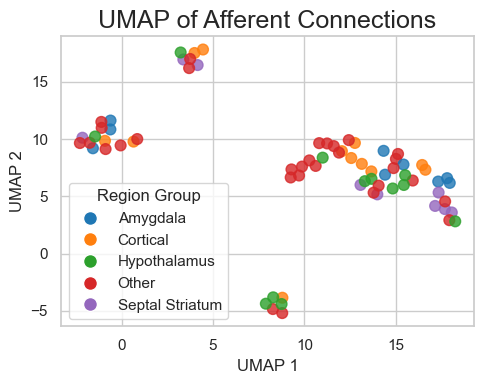

In [53]:
import umap
import matplotlib.pyplot as plt
from helpers import get_correlation_matrix, get_feature_vectors_shared

cosine_df_to = get_correlation_matrix(df_avg_to, distance_metric='cosine')

df_avg_to_shared, df_avg_from_shared = get_feature_vectors_shared()

dissimilarity_matrix = 1 - cosine_df_from

regions = list(df_avg_to_shared.columns)

# Assign each region to a group
region_groups = {}
for region in regions:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels = [region_groups[region] for region in regions]


# play with dimensions and reduce n_neighbors

# Compute UMAP embedding
reducer = umap.UMAP(n_neighbors=3, min_dist=0.6, random_state=42)
embedding = reducer.fit_transform(df_avg_to_shared.T)

umap_embedding = embedding

sns.set(style="whitegrid")

# Create a color palette
palette = sns.color_palette("tab10", len(set(region_labels)))
group_to_color = {group: palette[i] for i, group in enumerate(sorted(set(region_labels)))}
colors = [group_to_color[label] for label in region_labels]

# Plot
plt.figure(figsize=(5, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=60, alpha=0.8)

# Annotate with legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      label=group, markersize=10,
                      markerfacecolor=color)
           for group, color in group_to_color.items()]
plt.legend(handles=handles, title="Region Group")
plt.title("UMAP of Afferent Connections", fontsize=18)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()

plt.savefig('../output/UMAP_afferent_hpc_one_config.png')
plt.show()

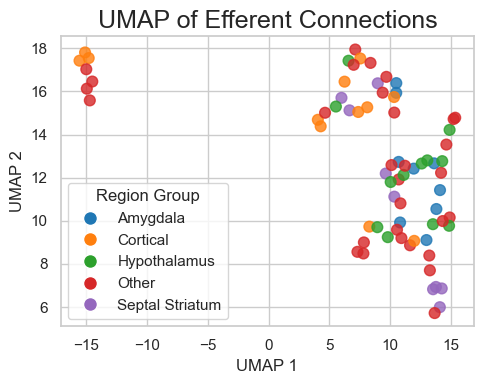

In [54]:
import umap
import matplotlib.pyplot as plt
from helpers import get_correlation_matrix

cosine_df_from = get_correlation_matrix(df_avg_from, distance_metric='cosine')

df_avg_to_shared, df_avg_from_shared = get_feature_vectors_shared()

dissimilarity_matrix = 1 - cosine_df_from

regions = list(df_avg_from_shared.columns)

# Assign each region to a group
region_groups = {}
for region in regions:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels = [region_groups[region] for region in regions]


# play with dimensions and reduce n_neighbors

# Compute UMAP embedding
reducer = umap.UMAP(n_neighbors=3, min_dist=0.6, random_state=42)
embedding = reducer.fit_transform(df_avg_from_shared.T)

umap_embedding = embedding

sns.set(style="whitegrid")

# Create a color palette
palette = sns.color_palette("tab10", len(set(region_labels)))
group_to_color = {group: palette[i] for i, group in enumerate(sorted(set(region_labels)))}
colors = [group_to_color[label] for label in region_labels]

# Plot
plt.figure(figsize=(5, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=60, alpha=0.8)

# Annotate with legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      label=group, markersize=10,
                      markerfacecolor=color)
           for group, color in group_to_color.items()]
plt.legend(handles=handles, title="Region Group")
plt.title("UMAP of Efferent Connections", fontsize=18)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()

plt.savefig('../output/UMAP_efferent_hpc_one_config.png')
plt.show()

In [10]:
# import hdbscan

# Cluster on the UMAP embedding
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
# cluster_labels = clusterer.fit_predict(umap_embedding)  # shape (n_samples,)

# Note: -1 means "noise" (unclustered points)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embedding)


df_clusters = pd.DataFrame({
    'cluster': cluster_labels,
    'group': region_labels
})

# Count how many points in each group per cluster
counts = df_clusters.groupby(['cluster', 'group']).size().unstack(fill_value=0)
print(counts)


group    Amygdala  Cortical  Hypothalamus  Other  Septal Striatum
cluster                                                          
0              17        28            15     57                5
1               2        18             5     13                5


In [11]:
17+28+15+57+5

122

In [12]:
28/122

0.22950819672131148

In [13]:
2+18+5+13+5

43

In [14]:
18/43

0.4186046511627907

In [15]:
(0.22958 + 0.4186)/2

0.32409

In [1]:
# Compute UMAP embedding
dissimilarity_matrix_a = 1 - spearman_df_to

regions_afferent = list(dissimilarity_matrix_a.index)

# Assign each region to a group
region_groups = {}
for region in regions_afferent:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels = [region_groups[region] for region in regions_afferent]

reducer = umap.UMAP(n_neighbors=3, min_dist=0.7, random_state=42)
embedding = reducer.fit_transform(df_avg_to.T)

sns.set(style="whitegrid")

# Create a color palette
palette = sns.color_palette("tab10", len(set(region_labels)))
group_to_color = {group: palette[i] for i, group in enumerate(sorted(set(region_labels)))}
colors = [group_to_color[label] for label in region_labels]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=60, alpha=0.8)

# Annotate with legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      label=group, markersize=10,
                      markerfacecolor=color)
           for group, color in group_to_color.items()]
plt.legend(handles=handles, title="Region Group")
plt.title("UMAP of Incoming Connections to Hippocampus", fontsize=18)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("../output/UMAP_afferent_hpc_one_config.svg")
plt.show()

NameError: name 'spearman_df_to' is not defined

# Run PCA on afferent and efferent connections


Explained variance ratio: [0.45350549 0.23425449 0.17737891 0.07513142 0.04567102 0.01405867
 0.        ]


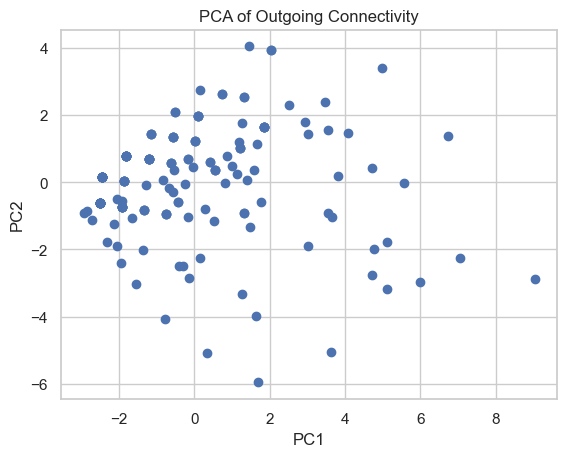

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# C is your N x N connectivity matrix
# Rows = source regions, columns = target regions
# Each row is a vector of outgoing connections from that region

# X = C.copy()  # Shape (N regions, N target regions)

X = df_avg_from.T

# Run PCA
pca = PCA()  # or choose 'n_components' to capture desired variance
X_pca = pca.fit_transform(X)

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot first two PCs
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Outgoing Connectivity")
plt.show()


Explained variance ratio: [0.5192406  0.17991728 0.15400992 0.06000344 0.03365845 0.03240564
 0.02076467]


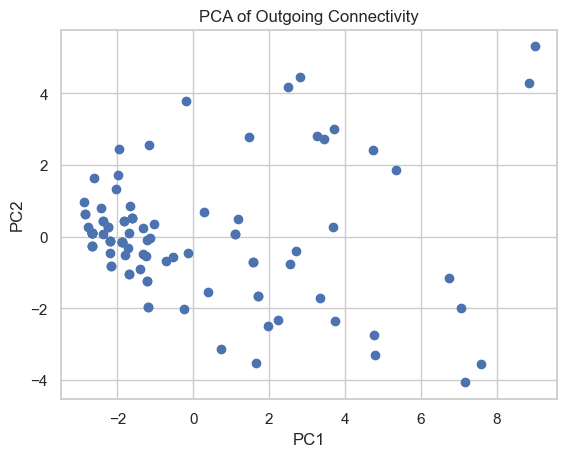

In [12]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# C is your N x N connectivity matrix
# Rows = source regions, columns = target regions
# Each row is a vector of outgoing connections from that region

# X = C.copy()  # Shape (N regions, N target regions)

X = df_avg_to.T

# Run PCA
pca = PCA()  # or choose 'n_components' to capture desired variance
X_pca = pca.fit_transform(X)

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot first two PCs
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Outgoing Connectivity")
plt.show()


# Iterate through n_neighbors and min_dist parameters in UMAP function

I will plot the efferent / afferent UMAP embeddings at different parameter values. This will result in 50 subplots total

In [10]:
def generate_subplots(n_neighbors_params, min_dist_params, data, region_labels, color_mapping):
    # Parameter values
    n_neighbors_list = n_neighbors_params
    min_dist_list = min_dist_params
    group_to_color = color_mapping

    projections = data.index
    
    # Set up the subplots
    fig, axes = plt.subplots(5, 5, figsize=(30, 30))
    
    # Loop through n_neighbors and min_dist to create subplots
    for i, n_neighbors in enumerate(n_neighbors_list):
        for j, min_dist in enumerate(min_dist_list):
            # Initialize UMAP with the current parameter settings
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
            X_umap = reducer.fit_transform(data)
    
            # Plot the UMAP result on the corresponding subplot
            ax = axes[i, j]
            # ax.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
    
            for k, group in enumerate(np.unique(region_labels)):
                # Select data points of the current group
                group_indices = [idx for idx, label in enumerate(region_labels) if label == group]
                ax.scatter(X_umap[group_indices, 0], X_umap[group_indices, 1], 
                           color=group_to_color[group], label=group, s=10, alpha=0.6)


                # for idx in group_indices:
                #     ax.text(X_umap[idx, 0], X_umap[idx, 1], str(projections[idx]), fontsize=8, alpha=0.8)
    
            
            ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
            ax.set_xticks([])
            ax.set_yticks([])
    
            # Add a legend in each subplot
            ax.legend(loc='best')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
    return fig

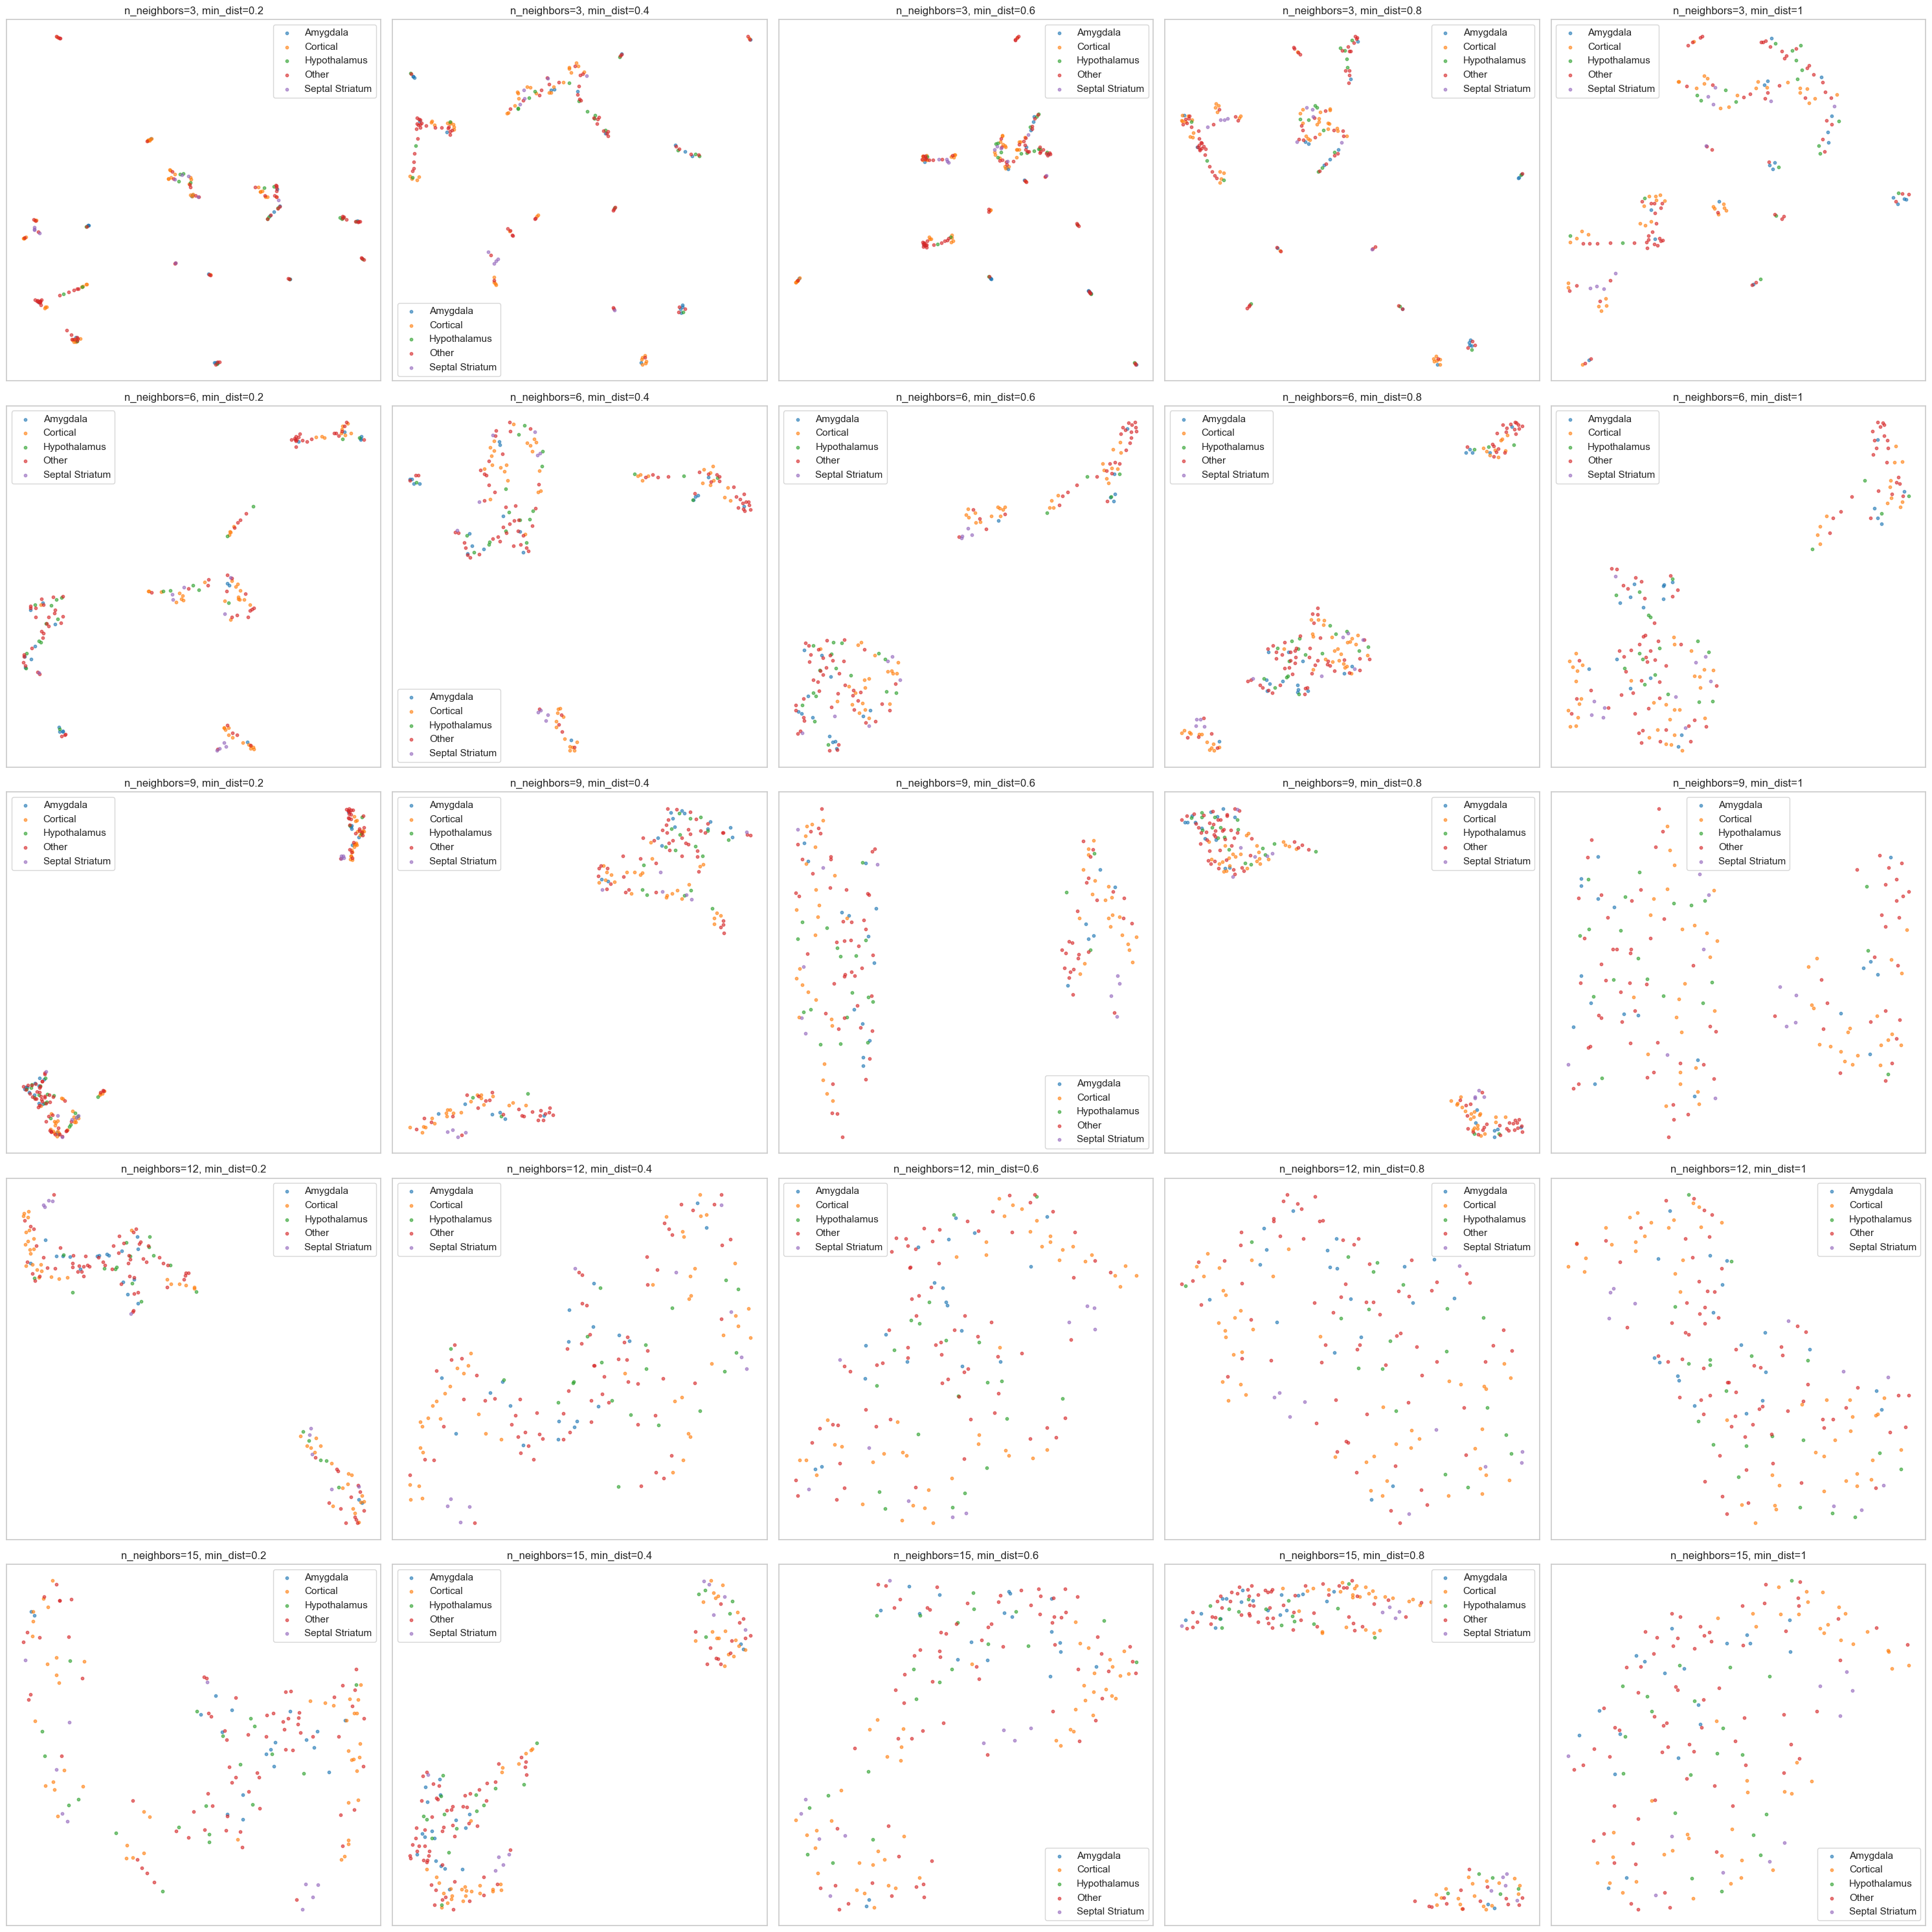

In [11]:
# 5x5 of UMAP to visualize the embedding at different values of parameters (efferent)
regions_efferent = list(df_avg_from.columns)

# Assign each region to a group
region_groups = {}
for region in regions_efferent:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels_efferent = [region_groups[region] for region in regions_efferent]

# Create a color palette
palette = sns.color_palette("tab10", len(set(region_labels_efferent)))
group_to_color_eff = {group: palette[i] for i, group in enumerate(sorted(set(region_labels_efferent)))}
# colors = [group_to_color[label] for label in region_labels]

fig = generate_subplots(n_neighbors_params=[3, 6, 9, 12, 15], 
                  min_dist_params=[0.2, 0.4, 0.6, 0.8, 1], 
                  data=df_avg_from.T, 
                  region_labels=region_labels_efferent,
                  color_mapping=group_to_color_eff)

fig.savefig('../output/UMAP_hpc_efferent.svg')

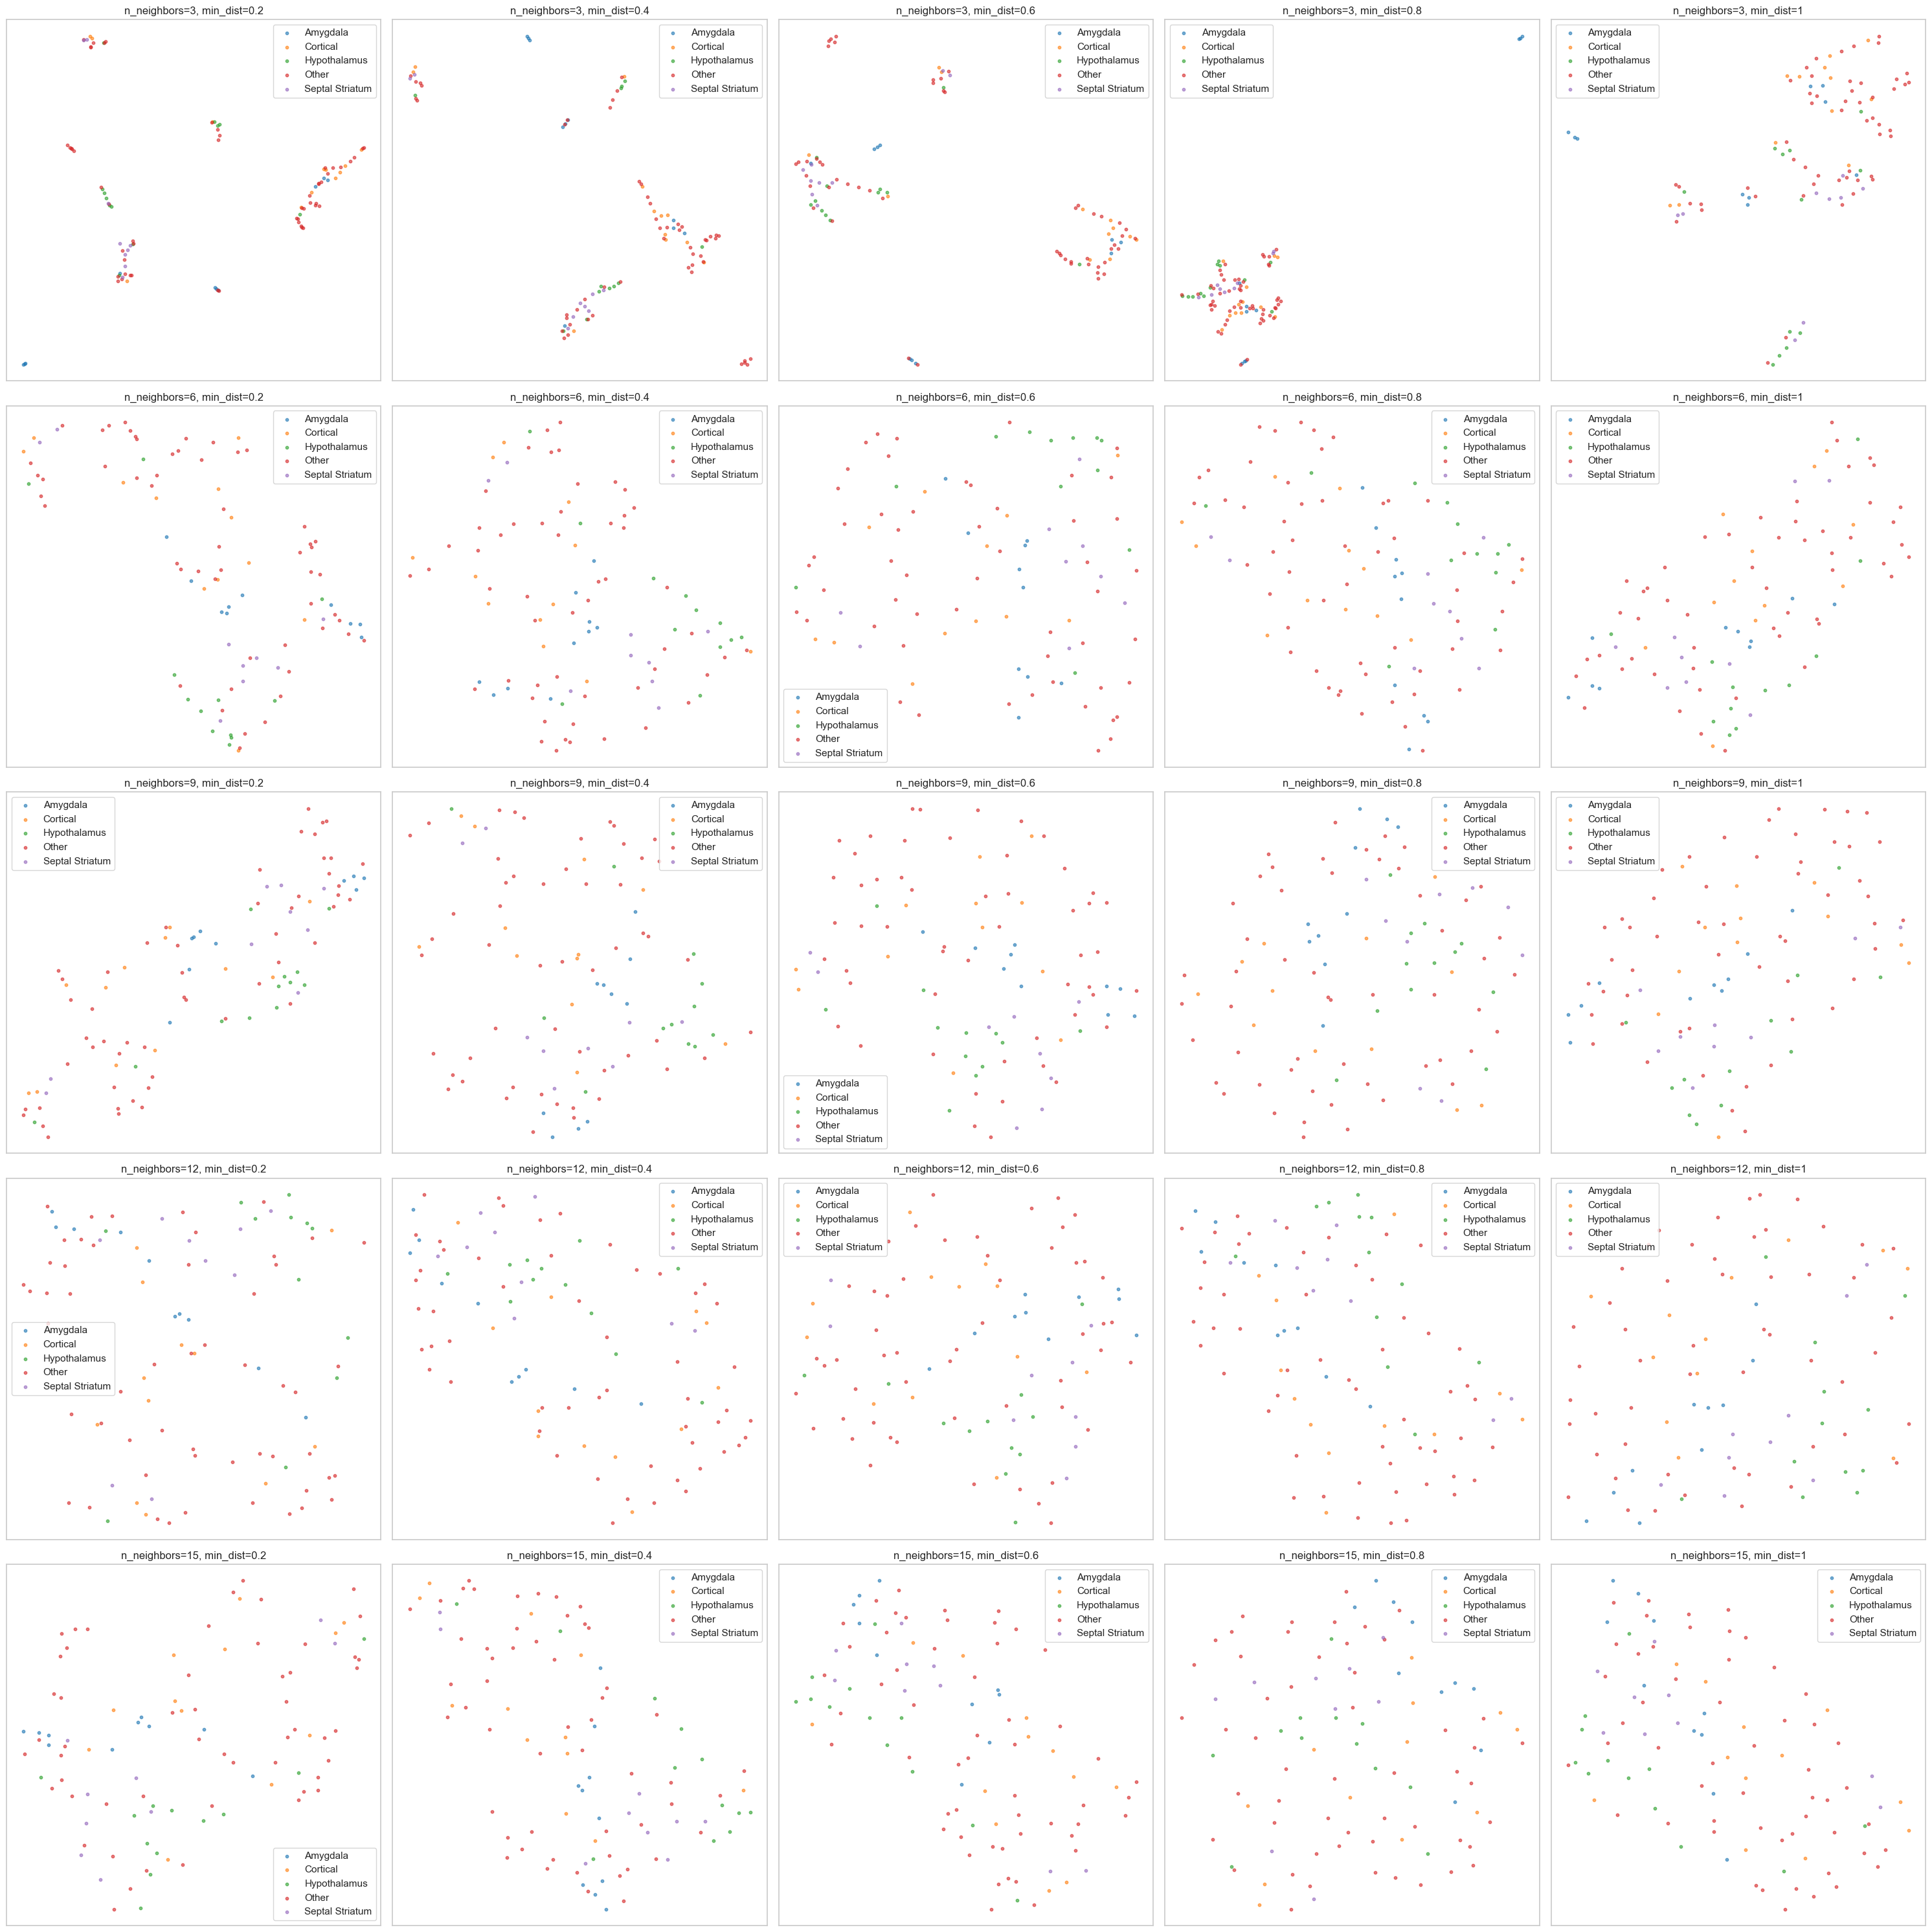

In [62]:
# 5x5 of UMAP to visualize the embedding at different values of parameters (afferent)
regions_afferent = list(df_avg_to.columns)


# Assign each region to a group
region_groups = {}
for region in regions_afferent:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels_afferent = [region_groups[region] for region in regions_afferent]

# Create a color palette
palette = sns.color_palette("tab10", len(set(region_labels_efferent)))
group_to_color_aff = {group: palette[i] for i, group in enumerate(sorted(set(region_labels_afferent)))}
# colors = [group_to_color[label] for label in region_labels]

fig = generate_subplots(n_neighbors_params=[3, 6, 9, 12, 15], 
                  min_dist_params=[0.2, 0.4, 0.6, 0.8, 1], 
                  data=df_avg_to.T, 
                  region_labels=region_labels_afferent,
                  color_mapping=group_to_color_aff)

fig.savefig('../output/UMAP_hpc_afferent.svg')

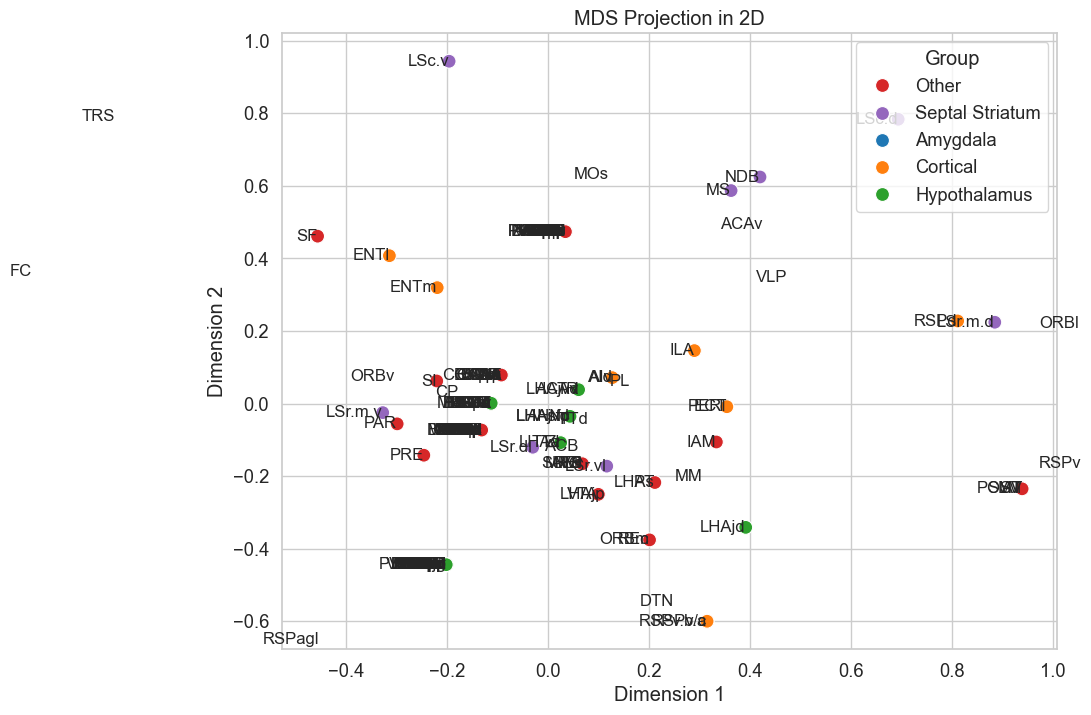

In [30]:
# do multidimensional scaling in 2D

dissimilarity_matrix_a = 1 - spearman_df_to

regions_afferent = list(dissimilarity_matrix_a.index)

# Assign each region to a group
region_groups = {}
for region in regions_afferent:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels = [region_groups[region] for region in regions_afferent]

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = mds.fit_transform(dissimilarity_matrix)

# Create a DataFrame for the results
mds_results = pd.DataFrame(embedding, columns=['Dim1', 'Dim2'], index=dissimilarity_matrix.index)
mds_results['Group'] = mds_results.index.map(region_groups)


# Plot the results
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

palette = sns.color_palette("tab10", len(set(region_labels)))
group_to_color = {group: palette[i] for i, group in enumerate(sorted(set(region_labels)))}

# Plot the results in 3D
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim1', y='Dim2', 
    data=mds_results, 
    hue='Group',  # Group coloring
    palette = group_to_color,
    # palette={'Cortical': 'red', 'Hypothalamus':'blue', 'Amygdala': 'purple', "Septal Striatum": 'pink','Other': 'green'}, 
    s=100, 
    marker='o'
)

# Annotate each point with its label
for label, (x, y, z) in mds_results.iterrows():
    plt.text(x, y, label, fontsize=12, ha='right', va='center')

# Add labels and title
plt.title("MDS Projection in 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")


plt.savefig("../output/MDS_2D_spearman_to.svg", format="svg")
# Show the plot
plt.show()

In [17]:
import numpy as np
import pandas as pd
import umap
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Dummy data (replace this with your own)
np.random.seed(42)

# define the labels
regions_afferent = list(df_avg_to.columns)

# Assign each region to a group
region_groups = {}
for region in regions_afferent:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels_afferent = [region_groups[region] for region in regions_afferent]

# Create a color palette
# palette = sns.color_palette("tab10", len(set(region_labels_afferent)))
# group_to_color_aff = {group: palette[i] for i, group in enumerate(sorted(set(region_labels_afferent)))}


# Widget sliders
n_neighbors_slider = widgets.IntSlider(value=15, min=2, max=20, step=1, description='n_neighbors')
min_dist_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.05, description='min_dist')

# UMAP plotting function
def plot_umap(n_neighbors, min_dist):
    region_labels = region_labels_afferent
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    embedding = reducer.fit_transform(df_avg_to.T)

    # X_umap = reducer.fit_transform(data)
    
    df = pd.DataFrame(embedding, columns=['x', 'y'])
    df["region"] = regions_afferent
    df["group"] = region_labels

    fig = px.scatter(
        df,
        x="x",
        y="y",
        color="group",
        hover_name="region",
        title=f"UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}",
        color_discrete_sequence=px.colors.qualitative.Set1  # You can customize this
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.show()

# Interactive display
ui = widgets.VBox([n_neighbors_slider, min_dist_slider])
out = widgets.interactive_output(plot_umap, {
    'n_neighbors': n_neighbors_slider,
    'min_dist': min_dist_slider
})

display(ui, out)


Output()

In [32]:
import numpy as np
import pandas as pd
import umap
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# EFFERENT

# Dummy data (replace this with your own)
np.random.seed(42)

# define the labels
regions_efferent = list(df_avg_from.columns)

# Assign each region to a group
region_groups = {}
for region in regions_efferent:
    if region in cortical_regions:
        region_groups[region] = "Cortical"
    elif region in hypothalamus_regions:
        region_groups[region] = "Hypothalamus"
    elif region in amygdala_aggregated_regions:
        region_groups[region] = "Amygdala"
    elif region in septostri_regions:
        region_groups[region] = "Septal Striatum"
    else:
        region_groups[region] = "Other"

region_labels_efferent = [region_groups[region] for region in regions_efferent]


# Widget sliders
n_neighbors_slider = widgets.IntSlider(value=15, min=2, max=20, step=1, description='n_neighbors')
min_dist_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.05, description='min_dist')

# UMAP plotting function
def plot_umap(n_neighbors, min_dist):
    region_labels = region_labels_efferent
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    embedding = reducer.fit_transform(df_avg_from.T)

    # X_umap = reducer.fit_transform(data)
    
    df = pd.DataFrame(embedding, columns=['x', 'y'])
    df["region"] = regions_efferent
    df["group"] = region_labels

    fig = px.scatter(
        df,
        x="x",
        y="y",
        color="group",
        hover_name="region",
        title=f"UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}",
        color_discrete_sequence=px.colors.qualitative.Set1, # You can customize this
        width=900,
        height=900
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.show()

# Interactive display
ui = widgets.VBox([n_neighbors_slider, min_dist_slider])
out = widgets.interactive_output(plot_umap, {
    'n_neighbors': n_neighbors_slider,
    'min_dist': min_dist_slider
})

display(ui, out)


Output()

In [19]:
len(df_avg_to.columns)

96

In [20]:
df_avg_to.columns

Index(['SI', 'MS', 'NDB', 'BSTam', 'BSTju', 'BSTrh', 'BSTpr', 'BSTif', 'BSTtr',
       'BSTd', 'LSr.m.v', 'LSr.m.d', 'LSr.vl', 'LSr.dl', 'LSc.v', 'LSc.d',
       'LSv', 'SF', 'AAA', 'MEAad', 'MEApv', 'MEApd', 'COApm', 'COApl', 'PAA',
       'TR', 'PRE', 'POST', 'PAR', 'ENTm', 'ENTl', 'ILA', 'RSPv.a', 'RSPv.b/c',
       'RSPd', 'AIv', 'PERI', 'ECT', 'BMAa', 'BMAp', 'BLAa', 'BLAp', 'LA',
       'PA', 'EPv', 'EPd', 'ADP', 'SCH', 'DMHa', 'DMHp', 'DMHv', 'PH', 'MPNm',
       'AHNc', 'AHNp', 'VMHa', 'PMv', 'TM', 'SUMm', 'SUMl', 'RCH', 'LHAa',
       'LHAjvv', 'LHAjd', 'LHAsfa', 'REr', 'REc', 'PVT', 'PT', 'AV', 'AD',
       'AMv', 'AMd', 'IAM', 'LD', 'PR', 'SMT', 'MDm', 'RH', 'CM', 'VAL', 'VM',
       'MT', 'RL', 'IF', 'IPN', 'CLI', 'CS', 'DR', 'SNc', 'SNr', 'VTA', 'RR',
       'PAGvm', 'NI', 'LC'],
      dtype='object', name='Abbr.')

In [25]:
'VISp' in df_avg_to.columns

False